# BINF3020 Lab 1 – Expression data analysis in Python: Questions

*Last revision:Wed 29 Oct 2025 22:31:42 AEDT.*  Revised version.

In [13]:
from IPython.display import display, HTML
display(HTML("<style>.container {width:90% !important;}</style>"))

## Introduction

In this lab/homework activity, you will answer some questions on topics from lectures and learn how to apply some of the techniques covered to representative datasets. We will be working with a number of microarray datasets and working on data preparation, cluster analysis and classification learning. You need to work through the notebook and complete the answers to questions in the notebook cells.

#### Please ensure each answer is completed in the single cell of the notebook immediately following the question, and that all answers are in ```markdown``` format !!!

Once you have completed the notebook, make sure you save it with the filename "Lab1_Solutions.ipynb" and submit it via Moodle.

All questions are worth 1 mark, so there are a total of *10 marks* available.

Total notebook marks will be scaled to a **course mark out of 5** to contribute to your course total.

**Deadline: 23:55pm, Monday November 10, 2025**.

Your environment should have already been set up to enable to run this notebook if you successfully completed the lab "Lab1_Intro_Python.ipynb". The main data structure we will be using is the ```DataFrame``` (something you are probably familiar with from R). The principal toolkit for handling DataFrames in Python is a library called ```Pandas```. You can find some useful information in compact form on basic use of [Pandas](https://towardsdatascience.com/how-to-master-pandas-8514f33f00f6) and another one on some more [advanced uses](https://towardsdatascience.com/learn-advanced-features-for-pythons-main-data-analysis-library-in-20-minutes-d0eedd90d086).

## Data Exploration

As a first step, whenever we get some data given to us we will start by doing some basic exploration ("know your data"). This will give us an idea of what is in the data and what types of analysis we may be able to do. 

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

df_train = pd.read_csv("/Users/nicoleconsolacion/binf3020lab/datasets/ALL_AML_train.csv")
df_train.shape

(7129, 78)

As we can see above, there are over 7,000 rows and 78 columns. From our knowledge of microarray data we would assume that the shape of this data frame suggests the rows correspond to genes and the columns to samples. Let us transpose the dataset and look at the first 5 rows.

In [16]:
df_train.head(5).T

,0,1,2,3,4
Gene Description,AFFX-BioB-5_at (endogenous control),AFFX-BioB-M_at (endogenous control),AFFX-BioB-3_at (endogenous control),AFFX-BioC-5_at (endogenous control),AFFX-BioC-3_at (endogenous control)
Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at
1,-214,-153,-58,88,-295
call,A,A,A,A,A
2,-139,-73,-1,283,-264
...,...,...,...,...,...
call.35,A,A,A,P,A
32,-124,-79,-37,330,-188
call.36,A,A,A,A,A
33,-135,-186,-70,337,-407


This appears to be Affymetrix data. 
However, it also looks like this dataset needs to be "cleaned" before starting any analysis, so that is what we will do next.

In [17]:
# pd.set_option('future.no_silent_downcasting', True)

# Read in the training and test datasets
train_dataset = pd.read_csv('./datasets/ALL_AML_train.csv')
test_dataset  = pd.read_csv('./datasets/ALL_AML_test.csv')

train_dataset1 = [col for col in train_dataset.columns if "call" not in col]
train_dataset  = train_dataset[train_dataset1]

test_dataset1 = [col for col in test_dataset.columns if "call" not in col]
test_dataset  = test_dataset[test_dataset1]

train_dataset = train_dataset.T
test_dataset = test_dataset.T

train_dataset2 = train_dataset.drop(['Gene Description','Gene Accession Number'],axis=0)
test_dataset2  = test_dataset.drop(['Gene Description','Gene Accession Number'],axis=0)

# Ensure data frame entries are numeric and indexing has the same order
train_dataset2.index = pd.to_numeric(train_dataset2.index)
train_dataset2.sort_index(inplace=True)

test_dataset2.index = pd.to_numeric(test_dataset2.index)
test_dataset2.sort_index(inplace=True)

print(f'Dataset sizes: ')
print(f'Training set: {train_dataset2.shape}')
print(f'Test set: {test_dataset2.shape}')

# Read in the classes and inspect the structure of the data
y = pd.read_csv('./datasets/ALL_AML_classes.csv')
print(f'Class distribution: ')
print(y['cancer'].value_counts())
y = y.replace({'ALL':0,'AML':1})

Dataset sizes: 
Training set: (38, 7129)
Test set: (34, 7129)
Class distribution: 
cancer
ALL    47
AML    25
Name: count, dtype: int64


/var/folders/36/6hzg_xl133b79khbgyx_knn00000gn/T/ipykernel_59395/1855202352.py:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace({'ALL':0,'AML':1})


We need to do some pre-processing to make sure the data is in a suitable format for the sklearn algorithms we will use, and also to scale the gene expression values as a normalization step.

In [18]:
# Training set
X_train = train_dataset2.reset_index(drop=True)
Y_train = y[y.patient <= 38].reset_index(drop=True)

# Test set
X_test = test_dataset2.reset_index(drop=True)
Y_test = y[y.patient > 38].reset_index(drop=True)

Y_test = Y_test.iloc[:,1].values
Y_train = Y_train.iloc[:,1].values

# refer to the Scikit-learn documentation to understand how StandardScaler works
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

Since the data is very high-dimensional and we only have a relatively small number of samples we will apply _dimensionality reduction_ using PCA.

**Q1. What does it mean to say that a dataset "is very high-dimensional" ?**

1. The dataset has a small number of samples and a small number of features
2. The dataset has a small number of samples and a large number of features
3. The dataset has a large number of samples and a small number of features
4. The dataset has a large number of samples and a large number of features
5. I have a different interpretation (write a sentence below explaining why you selected this answer)

**Q1 answer.** 
2. The dataset has a small number of samples and a large number of features
A dataset is described as “high-dimensional” when it has many features (variables). For example, thousands of genes, pixels or measurements per sample.

Now we turn to address the issue of high-dimensionality with PCA.

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components = None)
X_train_pca = pca.fit_transform(X_train)


In [20]:
# Calculating the "explained variance" of each principal component, up to 90% of the total variance
total = sum(pca.explained_variance_)
k = 0
current_variance = 0
while current_variance/total < 0.90:
      current_variance += pca.explained_variance_[k]
      k = k + 1
k

# Applying PCA to select the top k components capturing up to 90% of the variance
pca = PCA(n_components = k)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

var_exp = pca.explained_variance_ratio_.cumsum()
var_exp = var_exp*100

var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
print(f'PCA Dim: {k}; PCA Var: {var1}')

PCA Dim: 28; PCA Var: [14.99 26.97 33.57 38.45 43.08 46.8  50.29 53.58 56.57 59.22 61.73 64.09
 66.3  68.39 70.33 72.22 74.07 75.78 77.49 79.13 80.67 82.2  83.66 85.09
 86.51 87.89 89.24 90.55]


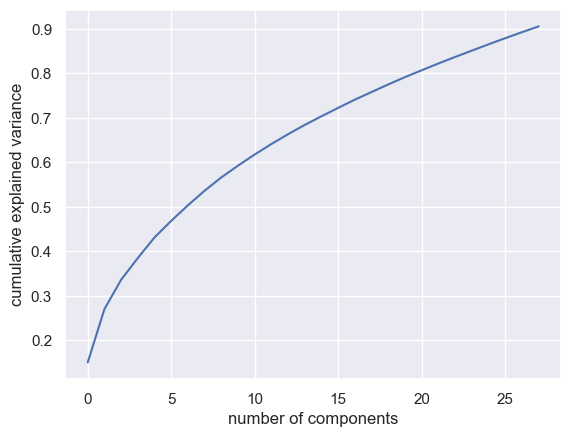

In [21]:
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.plot(np.cumsum(pca.explained_variance_ratio_))

**Q2. What is the reduction in the number of dimensions if we use the PCA transformed data instead of the original ?**

1. 28
2. 38
3. 72
4. 7101
5. 7129

**Q2 answer.**  
4. 7101 
This is because the original dimensionality was 7129 and the PCA-reduced dimensionality is 28

**Q3. In your own words, briefly explain what inference can be drawn from the results of this application of PCA to the dataset.**

**Q3 answer.**  
Most of the variation in the dataset can be explained by a very small number of components (28 out of 7129). Only 28 principal components capture about 90% of the total variance. This means that the data are highly correlated, many genes vary together and much of the information is redundant.

Now to visualize the data following this transform, we select only the first two principal components.

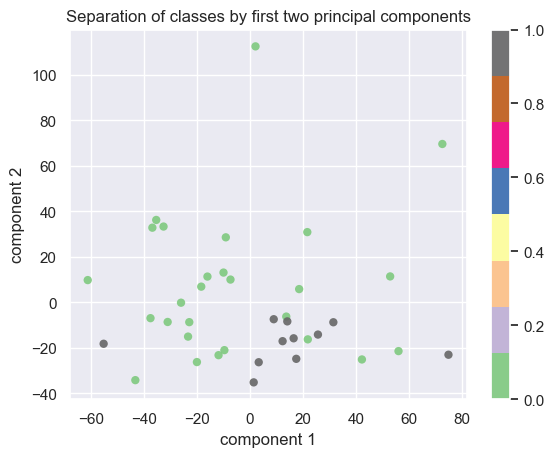

In [22]:
import matplotlib.cm

# plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1],c=Y_train, edgecolor='none', alpha=0.9, cmap=plt.cm.get_cmap('Spectral', 10))

# 'Qualitative' 'Setl'
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1],c=Y_train, edgecolor='none', alpha=0.9, cmap=matplotlib.colormaps['Accent'])

plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('Separation of classes by first two principal components')
plt.colorbar();

**Q4.  In your opinion, which of the following is the best explanation of the plot of the separation of the two classes when the data are projected only onto the first two principal components ?**

1. There is good class separation due to the large amount of explained variance from the first two principal components
2. There is only limited class separation although there is a large amount of explained variance from the first two principal components
3. There is good class separation although there is only a limited amount of explained variance from the first two principal components
4. There is only limited class separation due to the limited amount of explained variance from the first two principal components
5. None of the above

**Q4 answer.**  
4. There is only limited class separation although there is a large amount of explained variance from the first two principal components. 

The first two PCs explain a large portion of total variance, but that variance doesn’t fully correspond to the ALL/AML distinction, resulting in only partial class separation.

Alternatively, we could apply one of the methods designed to reduce dimensionality "automatically" to a pre-defined number of dimensions (Self-Organizing Maps, discussed in lectures, is one such method). Methods designed to enable visualisation, map input data to two dimensions. One such method is [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html), which we will use to provide another perspective on the data. You can find more information on t-SNE [here](https://lvdmaaten.github.io/tsne/).

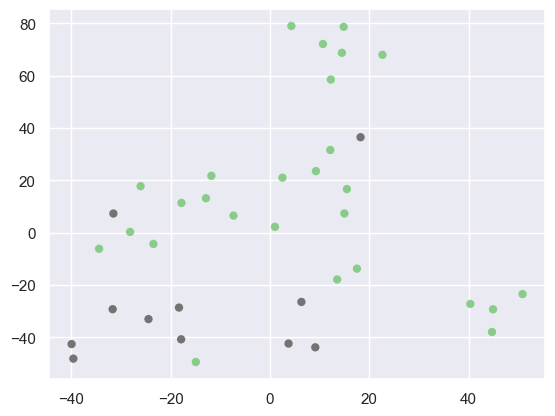

In [23]:
from sklearn import manifold

X = X_train
tsne = manifold.TSNE(n_components=2, init="random", random_state=0, perplexity=3)
res = tsne.fit_transform(X)

fig, ax = plt.subplots()
ax.scatter(res[:, 0], res[:, 1], c=Y_train, edgecolor='none', alpha=0.9, cmap=matplotlib.colormaps['Accent'])
plt.show()

**Q5. Do you think the results from applying tSNE to the original data are consistent with your answer to Q4 ? Answer yes or no, and provide a one-sentence justification for your choice.**

**Q5 answer.** 
Yes, The t-SNE plot also shows only limited separation between the two classes, consistent with the PCA result, indicating that while the data have complex structure, the ALL and AML samples are not clearly separable in lower-dimensional space.

## Classification

We have two options here. On one hand, now we know that dimensionality can be reduced, for example by PCA, we can try a standard linear classifier. However, since the data will be transformed by such dimensionality reduction it is not clear how this new representation relates to the original gene expression dataset. On the other hand, we could try a more powerful "black-box" classifier, such as ensemble learning using boosting on the original data, and see how that turns out.

To evaluate and compare two classifiers we will apply several widely-used metrics. First is the predictive accuracy of each classifer on the test set. Second, the 2x2 [confusion matrices](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) for the test set predictions are generated. Third, the [Mathews correlation coefficient (MCC)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html) is computed from the confusion matrices for both classifiers.

If you are not familiar with confusion matrices, here is the format of the confusion matrix evaluating a two-class predictive classifier, where the classes are denoted "positive" (Pos) and "negative" (Neg), although these are simply arbitrary labels. You can find more information on confusion matrices [here](https://en.wikipedia.org/wiki/Confusion_matrix).

| Actual | Predicted |   |
| :---   | :---: | :---: |
|        | Pos   | Neg   |
| Pos    | TP    | FN    |
| Neg    | FP    | TN    |


The Mathews correlation coefficient is often used in bioinformatics applications of machine learning as a single metric summarising the results in a confusion matrix. Useful information is in the Introduction of this [article](https://www.frontiersin.org/articles/10.3389/frobt.2022.876814/full) and more detail is in this [Wikipedia article](https://en.wikipedia.org/wiki/Phi_coefficient).

In [9]:
# Metrics for evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef

In [24]:
# Fitting a logistic regression classifier to the PCA-transformed version of the training set
from sklearn.linear_model import LogisticRegression

clf=LogisticRegression(penalty='l2',solver='liblinear',random_state=0)
clf.fit(X_train_pca,Y_train)

Y_pred=clf.predict(X_test_pca)

log_reg_ac = accuracy_score(Y_test, Y_pred)
log_reg_cm = confusion_matrix(Y_test, Y_pred)

print(f'Logistic Regression Accuracy: {log_reg_ac}')
print(log_reg_cm)

matthews_corrcoef(Y_test, Y_pred)

Logistic Regression Accuracy: 0.9117647058823529
[[19  1]
 [ 2 12]]


0.8174253462889596

In [25]:
# Fitting a gradient-boosting classifier to the training set
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)

grad_boost_ac = accuracy_score(Y_test, Y_pred)
grad_boost_cm = confusion_matrix(Y_test, Y_pred)

print(f'Gradient Boosting Accuracy: {grad_boost_ac}')
print(grad_boost_cm)

matthews_corrcoef(Y_test, Y_pred)

Gradient Boosting Accuracy: 0.9117647058823529
[[18  2]
 [ 1 13]]


0.821271097469555

**Q6 [1 mark]. From these results, what can you say about which classifier may be "better"?**

**Q6 answer.** While both models perform very similarly, the Gradient Boosting classifier shows a small but measurable advantage in overall predictive quality. This suggests that non-linear ensemble methods like boosting can capture subtle, complex patterns in the high-dimensional gene expression data that a linear model (like logistic regression) might slightly underfit


**Q7 [1 mark]. With reference to the materials above on confusion matrices, etc. provide some commentary on any further insight you might obtain about the relative performance of the two classification methods.**

**Q7 answer.** The confusion matrix and MCC provide crucial insight beyond accuracy. Even if two classifiers achieve similar accuracies, differences in their confusion matrices and MCCs can reveal which model is genuinely better at distinguishing classes, especially in biologically imbalanced datasets. The boosting classifier is likely to outperform the PCA-based linear model in balanced predictive power and overall robustness.


## Clustering

Turning our attention back to unsupervised learning, we start by loading the Yeast cell-cycle time series dataset.

In [26]:
# Load the Spellman dataset
df_sc = pd.read_csv("/Users/nicoleconsolacion/binf3020lab/datasets/gene800_Spellman.csv")
df_sc.shape
df_sc.info()
df_sc.head(2).T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 799 entries, 0 to 798
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   gene_name  799 non-null    object 
 1   X          799 non-null    float64
 2   X.1        799 non-null    float64
 3   X.2        799 non-null    float64
 4   X.3        799 non-null    float64
 5   X.4        799 non-null    float64
 6   X.5        799 non-null    float64
 7   X.6        799 non-null    float64
 8   X.7        799 non-null    float64
 9   X.8        799 non-null    float64
 10  X.9        799 non-null    float64
 11  X.10       799 non-null    float64
 12  X.11       799 non-null    float64
 13  X.12       799 non-null    float64
 14  X.13       799 non-null    float64
 15  X.14       799 non-null    float64
 16  X.15       799 non-null    float64
 17  X.16       799 non-null    float64
dtypes: float64(17), object(1)
memory usage: 112.5+ KB


,0,1
gene_name,YAL022C,YAL040C
X,-0.63,-0.05
X.1,-0.66,-0.15
X.2,-0.24,-0.58
X.3,-0.82,-0.58
X.4,-0.84,0.18
X.5,-0.89,-0.67
X.6,0.57,0.29
X.7,0.64,0.2
X.8,0.54,0.02


In [7]:
train_sc = df_sc.T
train_sc2 = train_sc.drop(['gene_name'], axis=0)
train_sc2.head(3)

,0,1,2,3,4,5,6,7,8,9,...,789,790,791,792,793,794,795,796,797,798
X,-0.63,-0.05,-0.07,0.53,-0.14,-0.65,-1.04,-0.4,0.0,-2.01,...,-0.96,0.73,-0.29,0.71,-0.63,0.12,-0.02,0.11,-0.41,-0.36
X.1,-0.66,-0.15,-0.58,-0.08,0.21,0.01,0.29,-0.99,-0.57,-1.25,...,0.0,-1.67,-0.57,-0.34,-0.38,0.55,0.76,0.27,0.18,0.0
X.2,-0.24,-0.58,-0.05,-0.25,0.84,1.52,1.45,-1.06,-0.32,0.37,...,-2.38,-0.56,0.44,-0.54,-0.32,1.55,1.43,0.16,0.51,0.49


Before clustering, try a visualization with t_SNE.

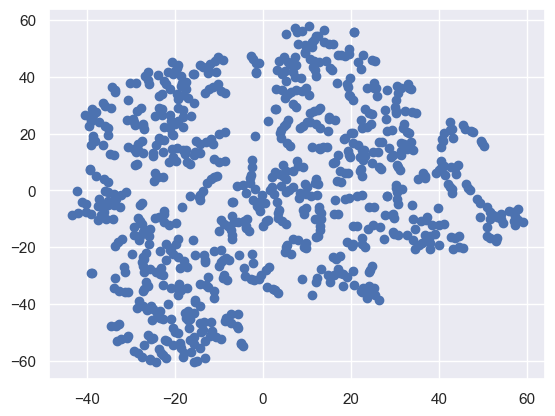

In [27]:
tsne_sc = manifold.TSNE(n_components=2, init="random", random_state=0, perplexity=10)
res_sc = tsne_sc.fit_transform(train_sc2.T)

fig, ax = plt.subplots()
ax.scatter(res_sc[:, 0], res_sc[:, 1])
plt.show()

**Q8. What can you infer about the possibility of finding a good clustering of this data from the t-SNE visualization ?**

**Q8 answer.**
The t-SNE plot suggests that the dataset lacks strong internal structure, meaning clustering algorithms (like k-means or hierarchical clustering) are unlikely to produce meaningful or well-separated clusters. The data points are too mixed to identify clear groups


In [28]:
from sklearn.cluster import KMeans

km_sc = KMeans(n_clusters=10, n_init=10)
km_sc.fit(train_sc2)

,n_clusters,10
,init,'k-means++'
,n_init,10
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,None
,copy_x,True
,algorithm,'lloyd'


In [29]:
from sklearn import metrics

for k in range(2,20):
    km_sc = KMeans(n_clusters=k, n_init=10)
#     km_sc.fit(train_sc2)
    km_sc.fit(train_sc2.T)
    lb_sc = km_sc.labels_
#     ss = metrics.silhouette_score(train_sc2, lb_sc, metric='sqeuclidean')
    ss = metrics.silhouette_score(train_sc2.T, lb_sc, metric='sqeuclidean')
    print(f'K = {k}, Silhouette score = {ss}')

K = 2, Silhouette score = 0.31564314949919225
K = 3, Silhouette score = 0.29272572932106183
K = 4, Silhouette score = 0.2739099796820917
K = 5, Silhouette score = 0.2629496034891162
K = 6, Silhouette score = 0.2005666848017396
K = 7, Silhouette score = 0.18225824983848207
K = 8, Silhouette score = 0.1694549051785451
K = 9, Silhouette score = 0.1823914366299754
K = 10, Silhouette score = 0.17658392807668297
K = 11, Silhouette score = 0.17747335601332842
K = 12, Silhouette score = 0.16939496460170386
K = 13, Silhouette score = 0.17411338009639726
K = 14, Silhouette score = 0.15960814526803285
K = 15, Silhouette score = 0.15862871813659263
K = 16, Silhouette score = 0.15342526104505877
K = 17, Silhouette score = 0.1592614848997859
K = 18, Silhouette score = 0.13780568080792374
K = 19, Silhouette score = 0.15225081356331618


**Q9. Which setting for "k" achieves the best clustering ?**

**Q9 answer.**  
K = 2 achieves the best clustering according to the silhoette score. Any meaningful grouping existing in tbe data is best represented by two clusters.


In [30]:
# Load the labels for the NCI60 dataset
df_nci_lb = pd.read_csv("./datasets/nci60_labs.csv")
print(df_nci_lb.shape)
df_nci_lb.x.value_counts(sort=True)

(64, 2)


x
RENAL          9
NSCLC          9
MELANOMA       8
BREAST         7
COLON          7
OVARIAN        6
LEUKEMIA       6
CNS            5
PROSTATE       2
UNKNOWN        1
K562B-repro    1
K562A-repro    1
MCF7A-repro    1
MCF7D-repro    1
Name: count, dtype: int64

In [31]:
# Load the microarray data for the NCI60 dataset
df_nci_dat = pd.read_csv("./datasets/nci60_data.csv")
print(df_nci_dat.shape)
print(df_nci_dat.T.head(3))

(64, 6831)
              0         1     2     3      4     5     6     7     8     9   \
Unnamed: 0    V1        V2    V3    V4     V5    V6    V7    V8    V9   V10   
1            0.3  0.679961  0.94  0.28  0.485  0.31 -0.83 -0.19  0.46  0.76   
2           1.18  1.289961 -0.04 -0.31 -0.465 -0.03   0.0 -0.87   0.0  1.49   

            ...    54    55    56       57    58    59    60    61    62    63  
Unnamed: 0  ...   V55   V56   V57      V58   V59   V60   V61   V62   V63   V64  
1           ...  0.01 -0.62 -0.38  0.04998  0.65 -0.03 -0.27  0.21 -0.05  0.35  
2           ... -1.28 -0.13   0.0 -0.72002  0.64 -0.48  0.63 -0.62  0.14 -0.27  

[3 rows x 64 columns]


In [32]:

df_nci_X = df_nci_dat.iloc[0:64,1:6831]

from sklearn.cluster import AgglomerativeClustering

avg = AgglomerativeClustering(linkage='average', metric='euclidean', n_clusters=20) 
avg.fit(df_nci_X)

nci_lbls = avg.labels_

nci_ss = metrics.silhouette_score(df_nci_X, nci_lbls, metric='sqeuclidean')
print(f'Silhouette score = {nci_ss}')

linkages = ['average', 'single', 'complete', 'ward']
for link_type in linkages:
    avg = AgglomerativeClustering(linkage=link_type, metric='euclidean', n_clusters=10)
    avg.fit(df_nci_X)
    nci_lbls = avg.labels_
    nci_ss = metrics.silhouette_score(df_nci_X, nci_lbls, metric='sqeuclidean')
    print(f'Silhouette score = {nci_ss}')
                                          

Silhouette score = 0.20587971878618905
Silhouette score = 0.18975672062168678
Silhouette score = 0.04240091462684446
Silhouette score = 0.19121437351322212
Silhouette score = 0.19922871941255466


**Q10. Can you find a better clustering by changing the number of clusters (set by the 'n_clusters=' parameter ?**

**Q10 answer.** _Add your code in the cell below and run it to generate output for the silhouette scores._


In [33]:
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics

best_score = -1
best_k = None

# Try a range of possible cluster numbers
for k in range(2, 21):  # you can expand this range if needed
    avg = AgglomerativeClustering(linkage='average', metric='euclidean', n_clusters=k)
    avg.fit(df_nci_X)
    nci_lbls = avg.labels_
    nci_ss = metrics.silhouette_score(df_nci_X, nci_lbls, metric='sqeuclidean')
    print(f'K = {k}, Silhouette score = {nci_ss:.3f}')
    
    if nci_ss > best_score:
        best_score = nci_ss
        best_k = k

print(f'\n Best silhouette score = {best_score:.3f} at K = {best_k}')

K = 2, Silhouette score = 0.262
K = 3, Silhouette score = 0.154
K = 4, Silhouette score = 0.144
K = 5, Silhouette score = 0.112
K = 6, Silhouette score = 0.112
K = 7, Silhouette score = 0.139
K = 8, Silhouette score = 0.145
K = 9, Silhouette score = 0.197
K = 10, Silhouette score = 0.190
K = 11, Silhouette score = 0.189
K = 12, Silhouette score = 0.183
K = 13, Silhouette score = 0.193
K = 14, Silhouette score = 0.216
K = 15, Silhouette score = 0.227
K = 16, Silhouette score = 0.222
K = 17, Silhouette score = 0.223
K = 18, Silhouette score = 0.216
K = 19, Silhouette score = 0.202
K = 20, Silhouette score = 0.206

 Best silhouette score = 0.262 at K = 2
